<a href="https://colab.research.google.com/github/Winnie207/Web/blob/master/Disney.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Import

In [7]:
pip install pyproj

In [0]:
import random
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyproj import Geod

Class

In [0]:
class Route():

    def __init__(self, request, time_open, time_close):
        self.request    = request
        self.time_open  = time_open
        self.time_close = time_close

    def read_time(self, file):
        data       = pd.read_csv(file).values.T
        self.index = data[0]
        self.time  = data[1::]

    def generate(self, individual):
        order = np.array([np.random.choice(self.request, len(self.request), replace=False) for i in range(individual)])
        self.order = order

    def crossover(self, evaluation):

        population_c = np.empty((len(self.order), len(self.request)), dtype=int)

        for i in range(0, len(self.order), 2):

            parents   = np.random.choice(len(self.order), 2, replace=False, p=evaluation)
            crossover = np.random.choice(len(self.request), 2, replace=False)

            if crossover[0] > crossover[1]:  crossover[0], crossover[1] = crossover[1], crossover[0]

            population_c[i]   = self.order[parents[0]].copy()
            population_c[i+1] = self.order[parents[1]].copy()
        
            for j in range(crossover[0], crossover[1]+1):

                index0 = np.where(population_c[i]   == self.order[parents[1]][j])
                index1 = np.where(population_c[i+1] == self.order[parents[0]][j])

                population_c[i][j],   population_c[i][index0[0][0]]   = population_c[i][index0[0][0]],   population_c[i][j]
                population_c[i+1][j], population_c[i+1][index1[0][0]] = population_c[i+1][index1[0][0]], population_c[i+1][j]
    
        self.order =  population_c.copy()

In [0]:
class FastPass(Route):

     def calculate_fastpass(self):

        time_loss  = np.full(len(self.order), self.time_open)
        ticket     = self.order.copy()

        for i in range(len(self.request)):
            t            = time_loss.reshape(-1,1)
            index        = np.argmax(np.where(self.index<=t,self.index,0), axis=1)
            ticket[:, i] = self.time[self.order[:,i], index]
            time_loss    = np.where((ticket[:,i]-time_loss>=120)|(ticket[:,i]==0), time_loss+120, ticket[:,i])
            time_loss    = np.where(ticket[:,i]==0, time_loss-120, time_loss)  # スマートじゃない！

        return ticket

In [0]:
class StandBy(Route):

    def read_coordinate(self, file, walking_speed):

        coord   = pd.read_csv(file, usecols=[1,2])
        coord_x = np.tile(coord['east'], (len(coord),1))
        coord_y = np.tile(coord['north'], (len(coord),1))

        distance = Geod(ellps='WGS84').inv(coord_x, coord_y, coord_x.T, coord_y.T)
        distance = distance[2] / (walking_speed * 1000 / 60)  # 歩行速度（km/h → m/min）
    
        self.distance = distance
    
    def calculate_standby(self, ticket, fp_order):

        time_loss  = np.full(len(self.order), self.time_open)
        time_lost  = time_loss.copy()
        time_loss += self.distance[0, self.order[:,0]]

        for i in range(len(self.request)-1):

            t          = time_loss.reshape(-1,1)
            index      = np.argmax(np.where(self.index<=t,self.index,0), axis=1)
            a          = np.where(self.order[:,i].reshape(-1,1) == fp_order)  # ticketのインデックスを取得
            time_loss += np.where((ticket[a[0],a[1]]<=time_loss)&(time_loss<=ticket[a[0],a[1]]+60), 20, self.time[self.order[:,i],index])

            # パレード
            parade    = np.where((ticket[a[0],a[1]]<=1235)&(1235<=ticket[a[0],a[1]]+60), 1235+20, 1235+self.time[self.order[:,i],26])
            time_loss = np.where((time_lost<=1200)&(1200<time_loss), parade, time_loss)  # time_walkingをどうやって入れるか？
            time_lost = time_loss.copy()

            time_loss += self.distance[self.order[:,i], self.order[:,i+1]]

        a          = np.where(self.order[:,-1].reshape(-1,1) == fp_order)
        time_loss += np.where((ticket[a[0],a[1]]<=time_loss)&(time_loss<=ticket[a[0],a[1]]+60), 20, self.time[self.order[:,-1],index])
        parade     = np.where((ticket[a[0],a[1]]<=1235)&(1235<=ticket[a[0],a[1]]+60), 1235+20, 1235+self.time[self.order[:,-1],26])
        time_loss  = np.where((time_lost<=1200)&(1200<time_loss), parade, time_loss)  # time_walkingをどうやって入れるか？
        time_loss += self.distance[self.order[:,-1], 0]

        self.time_loss = time_loss.copy()

    def score(self):

        score      = self.time_close - self.time_loss

        if max(score)-min(score) > 0:
            evaluation = (score - min(score)) / (max(score) - min(score))
            evaluation = evaluation / sum(evaluation)

        else: evaluation = [0] * len(self.request)
        
        return score, evaluation

Calculate / Output

In [0]:
request = [6,8,14,17,18,21,22,23,24,25,27,28,29]
request = request[:10]

individual = 100
generation = 100
time_open  =  8.0 * 60
time_close = 22.0 * 60

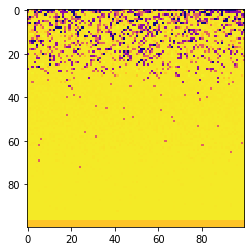


 [[ 14   6  23  22   8  24  17  18  25  21]
 [ 18  25   8  14  24  22   6  17  23  21]
 [  0   0   0 510   0   0 765   0   0   0]] 

Score: 418.42996686700724


In [15]:
# インスタンスの生成
fp = FastPass(request, time_open,time_close)
sb = StandBy(request, time_open, time_close)

# データの読み込み
fp.read_time('FP.csv')
sb.read_time('WaitingTime.csv')
sb.read_coordinate('Coordinate.csv', 2)

# 個体群の生成
fp.generate(individual)
sb.generate(individual)

# ヒートマップの作成
heatmap = np.zeros((generation, individual))

# 交配
for i in range(generation):
    
    ticket = fp.calculate_fastpass()
    sb.calculate_standby(ticket, fp.order)

    score, evaluation = sb.score()
    heatmap[i] = score
    if sum(evaluation) == 0: break
    
    fp.crossover(evaluation)
    sb.crossover(evaluation)

# ヒートマップ・ルートの表示
plt.imshow(heatmap, cmap='plasma')
plt.show()
index = score.argmax()
best  = np.array([sb.order[index], fp.order[index], ticket[index]])
print('\n', best, '\n\nScore:', score.max())